# <u>Hackerearth Deep Learning 2 Challenge

## <u> Importing the Important stuff

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time
import os
from tqdm import tqdm
from keras.utils import to_categorical
from keras_tqdm import TQDMNotebookCallback
import time
import seaborn as sns
%matplotlib inline

## <u>Data Preprocessing 

There are two csv files: testing and training files.
<br>We load both of them and look at the data 

In [2]:
# load training and test data csv files
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# see the structure of contents of the training csv file
train_data.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [4]:
# see the structure of contents of the test csv file
test_data.head()

,row_id,age,gender,view_position,image_name
0,id_100,47,M,0,scan_000100.png
1,id_10002,28,M,0,scan_00010002.png
2,id_10005,56,F,0,scan_00010005.png
3,id_10008,41,M,1,scan_00010008.png
4,id_10009,56,F,1,scan_00010009.png


In [5]:
# see the stats related to training data
train_data.describe()

,age,view_position
count,18577.000000,18577.000000
mean,47.972601,0.573343
std,16.741076,0.494605
min,2.000000,0.000000
25%,36.000000,0.000000
50%,50.000000,1.000000
75%,60.000000,1.000000
max,414.000000,1.000000


In [6]:
# see stats related to test data
test_data.describe()

,age,view_position
count,12386.000000,12386.000000
mean,48.028984,0.579445
std,16.660680,0.493668
min,1.000000,0.000000
25%,36.000000,0.000000
50%,50.000000,1.000000
75%,60.000000,1.000000
max,152.000000,1.000000


In [7]:
print('Unique classes: {}'.format(train_data['detected'].nunique()))

Unique classes: 14


So there are 18577 training and 12386 test images.

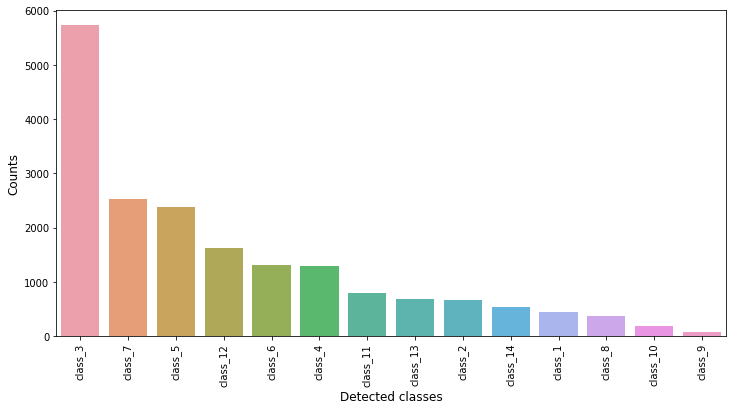

In [8]:
# histogram for the output classes
detected_counts = train_data.detected.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(detected_counts.index, detected_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Detected classes', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

### For resizing the images in a given resolution and saving on th disk for faster loading later on.

Make a folder named dataset.Inside it make a folder **train128** to store the resized pictures.
<br>The Structure will look like this : **dataset\train128**.
<br>Place the **train_** and **test_** folders in outside dataset folder. That is the structure will be: **\train_**

In [ ]:
def save_file(source, dest, img_size):
    for img_path in tqdm(train_data['image_name'].values):
        img = cv2.imread(source + img_path, 0)
        img = cv2.resize(img, (img_size, img_size))
        cv2.imwrite(dest + img_path, img)
    del img

In [ ]:
# set the source folder and destination folder
source = 'train_\\'
dest = 'dataset\\train128
img_size = 64
save_file(source, dest, img_size)

## make output training labels

In [3]:
class_list = train_data['detected'].tolist()
# make a mapping of different classes with integer values
class_dict = {name:counter+1 for counter, name in enumerate(set(class_list))}
# create output labels
y_train = [class_dict[k] for k in class_list]

In [4]:
# change the output labels to one hot encoding
y_train = to_categorical(y_train)
y_train.shape

(18577, 15)

### Training image Visualization

In [ ]:
index = np.random.randint(0, train_data.shape[0]-1)
img = cv2.imread(TRAIN_PATH + train_data['image_name'].iloc[index])
plt.imshow(img)
print("Image dimension:{}\nImage Resolution: {} X {}".format(img.shape, IMG_SIZE, IMG_SIZE))

# Pretrained Model:   VGG16

We will be using Transfer learning so , we will use VGG16 model

In [23]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [8]:
TRAIN_PATH = 'dataset\\train128\\' 
X_train=[]

for i in tqdm(range(len(train_data))): #, target_size=(128,128)
    temp_img=image.load_img(TRAIN_PATH+train_data['image_name'][i])
    temp_img=image.img_to_array(temp_img)
    X_train.append(temp_img)

100%|█████████████████████████████████████████████████████████████| 18577/18577 [03:28<00:00, 89.08it/s]


In [9]:
# converting train images to array 
X_train = np.array(X_train) 
X_train.shape

(18577, 128, 128, 3)

In [10]:
# applying mean subtraction processing
X_train = preprocess_input(X_train)

In [12]:
# Extracting features from the train dataset using the VGG16 pre-trained model
model = VGG16(weights='imagenet', include_top=False)

In [13]:
features_train = np.array(model.predict(X_train))

In [14]:
features_train.shape

(18577, 4, 4, 512)

We will save the output from the pretrained model just before its FC layer and use it for our Neural network.

In [15]:
# save the file
np.save('vgg16_tr_full_128.npy', features_train)    

In [16]:
del features_train

## <U> Model Creation

In [5]:
# First import the keras libraries
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import applications
from keras import optimizers 
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.io_utils import HDF5Matrix

In [6]:
early_stop = EarlyStopping(patience=3, monitor='acc', verbose = 0)

In [7]:
# make model checkpoint
file_path="weights.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=1, save_best_only=True, mode='max')

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

## Model 
Score: 0.30561

In [9]:
tensor_board = TensorBoard(log_dir='./logvgg', histogram_freq=0, batch_size=32, 
                           write_graph=True, write_grads=False, write_images=False, 
                           embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)


In [10]:
# load the features
X_train = np.load('vgg16_tr_full_128.npy')

## FC Model 


In [11]:
X_train.shape

(18577, 4, 4, 512)

In [12]:
# reshape the numpy matrix such that can be feed as input for the FC Neural Network
X_train = X_train.reshape(X_train.shape[0],-1)
X_train.shape

(18577, 8192)

In [13]:
model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1], use_bias=False, kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, use_bias=False, kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
         
model.add(Dense(256, use_bias=False,  kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(units = 15, activation='softmax', use_bias=False, kernel_initializer='glorot_uniform'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [75]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              8388608   
_________________________________________________________________
batch_normalization_9 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_9 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              1048576   
_________________________________________________________________
batch_normalization_10 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_10 (Activation)   (None, 1024)              0         
__________

### Now start Training
We have designed the CNN architecture ,now we will train it

In [ ]:
# load the best model weights
try:
    model.load_weights(file_path) # load the best model
except:
    pass # no file found

In [19]:
t1 = time.time()
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=100, verbose=2, 
                    callbacks=[TQDMNotebookCallback(leave_inner=False), checkpoint, tensor_board, early_stop],
                    validation_split=0.0,  shuffle=True, initial_epoch=0)
t2 = time.time()

elapsed = t2 - t1
print(str(elapsed/60) + ' minutes')

A Jupyter Widget

A Jupyter Widget

Epoch 1/10
Epoch 00001: loss did not improve
 - 21s - loss: 0.2490 - acc: 0.9176


A Jupyter Widget

Epoch 2/10
Epoch 00002: loss did not improve
 - 21s - loss: 0.2452 - acc: 0.9151


A Jupyter Widget

Epoch 3/10
Epoch 00003: loss did not improve
 - 21s - loss: 0.2083 - acc: 0.9282


A Jupyter Widget

Epoch 4/10
Epoch 00004: loss did not improve
 - 21s - loss: 0.2115 - acc: 0.9263


A Jupyter Widget

Epoch 5/10
Epoch 00005: loss did not improve
 - 21s - loss: 0.2018 - acc: 0.9317


A Jupyter Widget

Epoch 6/10
Epoch 00006: loss did not improve
 - 21s - loss: 0.1852 - acc: 0.9363


A Jupyter Widget

Epoch 7/10
Epoch 00007: loss did not improve
 - 21s - loss: 0.1657 - acc: 0.9428


A Jupyter Widget

Epoch 8/10
Epoch 00008: loss did not improve
 - 21s - loss: 0.1544 - acc: 0.9466


A Jupyter Widget

Epoch 9/10
Epoch 00009: loss did not improve
 - 21s - loss: 0.1760 - acc: 0.9392


A Jupyter Widget

Epoch 10/10
Epoch 00010: loss did not improve
 - 21s - loss: 0.1648 - acc: 0.9430
3.5379504362742105 minutes


In [20]:
#save the model
model.save('vgg_model.h5')

### <u>Loading the Test dataset for making predictions

In [24]:
TEST_PATH = 'dataset\\test128\\'
X_test=[]

for i in tqdm(range(len(test_data))): #, target_size=(128,128)
    temp_img=image.load_img(TEST_PATH+test_data['image_name'][i])
    temp_img=image.img_to_array(temp_img)
    X_test.append(temp_img)

100%|████████████████████████████████████████████████████████████| 12386/12386 [01:47<00:00, 115.33it/s]


In [25]:
# converting train images to array 
X_test = np.array(X_test) 
X_test.shape

(12386, 128, 128, 3)

In [26]:
# applying mean subtraction processing
X_test = preprocess_input(X_test)

In [27]:
# Extracting features from the train dataset using the VGG16 pre-trained model
model = VGG16(weights='imagenet', include_top=False)  

In [28]:
features_test = np.array(model.predict(X_test))

In [29]:
# save the file
np.save('vgg16_te_full_128.npy', features_test) 

### Now we will make predictions

In [ ]:
# load the best model weights
try:
    model.load_weights(file_path) # load the best model
except:
    pass # no file found

In [37]:
# identical to the previous one
model = load_model('vgg_model.h5')

In [32]:
# load the saved test input 
X_test = np.load('vgg16_te_full_128.npy')

In [33]:
X_test.shape

(12386, 4, 4, 512)

In [34]:
# reshape to suit the FC layer
X_test = X_test.reshape(X_test.shape[0],-1)
X_test.shape

(12386, 8192)

In [38]:
# make predictions
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [39]:
predictions.shape

(12386,)

In [40]:
# make a reverse mapping dict for labelling
rev_class_dict = {counter: name for name, counter in class_dict.items()}
pred_labels = [rev_class_dict[k] for k in predictions]

In [42]:
sub = pd.DataFrame({'row_id':test_data.row_id, 'detected':pred_labels})
sub = sub[['row_id', 'detected']]
filename = 'submission_vgg.csv'
sub.to_csv(filename, index=False) 
sub.head()

,row_id,detected
0,id_100,class_6
1,id_10002,class_14
2,id_10005,class_3
3,id_10008,class_3
4,id_10009,class_6
